In [54]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from typing import List, Dict, Union, Optional, Any
import matplotlib.pyplot as plt

def find_tensorboard_file(folder: str) -> Optional[str]:
    """
    Search for TensorBoard file (.tfevents) in a folder.

    Args:
        log_dir (str): Path to directory with log file.

    Returns:
        Optional[str]: Complete path to .tfevents file if found else None.
    """
    if not os.path.isdir(folder):
        print(f"Error: folder {folder} does not exist.")
        return None
    
    # Find the tensorBoard file
    for filename in os.listdir(folder):
        if filename.startswith("events.out"):
            # Return its complete path
            return os.path.join(folder, filename)
            
    print(f"No TensorBoard found in {folder}.")
    return None

def extract_scalars(file_path: str) -> Dict[str, List[float]]:
    """
    Extract scalar metrics saved in a TendorBoard file.

    Args:
        event_file_path (str): Path to a .tfevents file.

    Returns:
        Dict[str, List[float]]: Dictionary with the scalar metrics saved in the file.
    """
    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found.")
        return {}
    
    event_acc = EventAccumulator(file_path)
    event_acc.Reload()
    extracted_metrics = {}
    scalar_tags = event_acc.Tags()['scalars']
    
    # For each tag
    for tag in scalar_tags:
        # Save all values in a list
        values_list = [event.value for event in event_acc.Scalars(tag)]
        
        # List in a dictionary with tag as key
        extracted_metrics[tag] = values_list
    
    return extracted_metrics

def plot_scalar(list_of_dicts: List[Dict], metric_to_plot: str, max_value: float=2.5):
    """
    Plots the values for a specified metric across different models and groups.
    It automatically finds all relevant keys (e.g., 'global/loss', 'group0/loss').

    Args:
        list_of_dicts (List[Dict[str, List[float]]]): A list of dictionaries with data.
        metric_to_plot (str): The metric to plot (e.g., 'loss' or 'accuracy').
    """
    # Dynamically find all relevant keys to plot
    keys_to_plot = []
    # Use the first dictionary to find the keys, assuming all follow the same pattern
    first_dict = list_of_dicts[0]
    for key in first_dict.keys():
        if metric_to_plot in key:
            keys_to_plot.append(key)
    
    if not keys_to_plot:
        print(f"Errore: Nessuna chiave contenente '{metric_to_plot}' trovata nei dizionari.")
        return

    # Determine the number of subplots and grid layout
    num_plots = len(keys_to_plot)
    cols = min(2, num_plots)
    rows = (num_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))
    
    # Flatten the axes array for easier iteration, handling the single subplot case
    if num_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    markers = ['o', 's', '^', 'D', 'p', '*', 'h', 'v', '>', '<', 'x', '+']

    # Iterate over the keys to plot, one for each subplot
    for idx, key in enumerate(keys_to_plot):
        ax = axes[idx]
        
        # Check if the key exists in at least one dictionary
        if not any(key in d for d in list_of_dicts):
            ax.set_title(f"No data for '{key}'")
            continue
            
        # Iterate over each dictionary to plot a line on the current subplot
        for i, data_dict in enumerate(list_of_dicts):
            if key in data_dict:
                values = data_dict[key]
                
                # Applica il "capping" se è stata definita una soglia
                if max_value is not None:
                    # Crea una nuova lista con i valori modificati
                    c_values = [v if v <= max_value else max_value for v in values]
                else:
                    c_values = values
                
                style = markers[i % len(markers)]
                ax.plot(c_values, label=f'Model {data_dict["name"]}')
        
        ax.set_title(f'{key}')
        ax.set_xlabel('Rounds')
        ax.set_ylabel(key)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [55]:
path = "output/FedAvg/my-pre"
file = find_tensorboard_file(path)
fed = extract_scalars(file)
fed["name"] = "FedAvg"

path = "output/ClusterAvg/eC-pre"
file = find_tensorboard_file(path)
eC = extract_scalars(file)
eC["name"] = "eC"

path = "output/ClusterAvg/s0-pre"
file = find_tensorboard_file(path)
s0 = extract_scalars(file)
s0["name"] = "s0"

path = "output/ClusterAvg/s1-pre"
file = find_tensorboard_file(path)
s1 = extract_scalars(file)
s1["name"] = "s1"

path = "output/ClusterAvg/s1-pre-abstain"
file = find_tensorboard_file(path)
s1_abs = extract_scalars(file)
s1_abs["name"] = "s1-abstain"

path = "output/ClusterAvg/s1-pre-balance"
file = find_tensorboard_file(path)
s1_bal = extract_scalars(file)
s1_bal["name"] = "s1-balance"

path = "output/ClusterAvg/s1-pre-abs-bal"
file = find_tensorboard_file(path)
s1_abbal = extract_scalars(file)
s1_abbal["name"] = "s1-abbal"


lista = [fed, s1, s1_bal, s1_abs, s1_abbal]

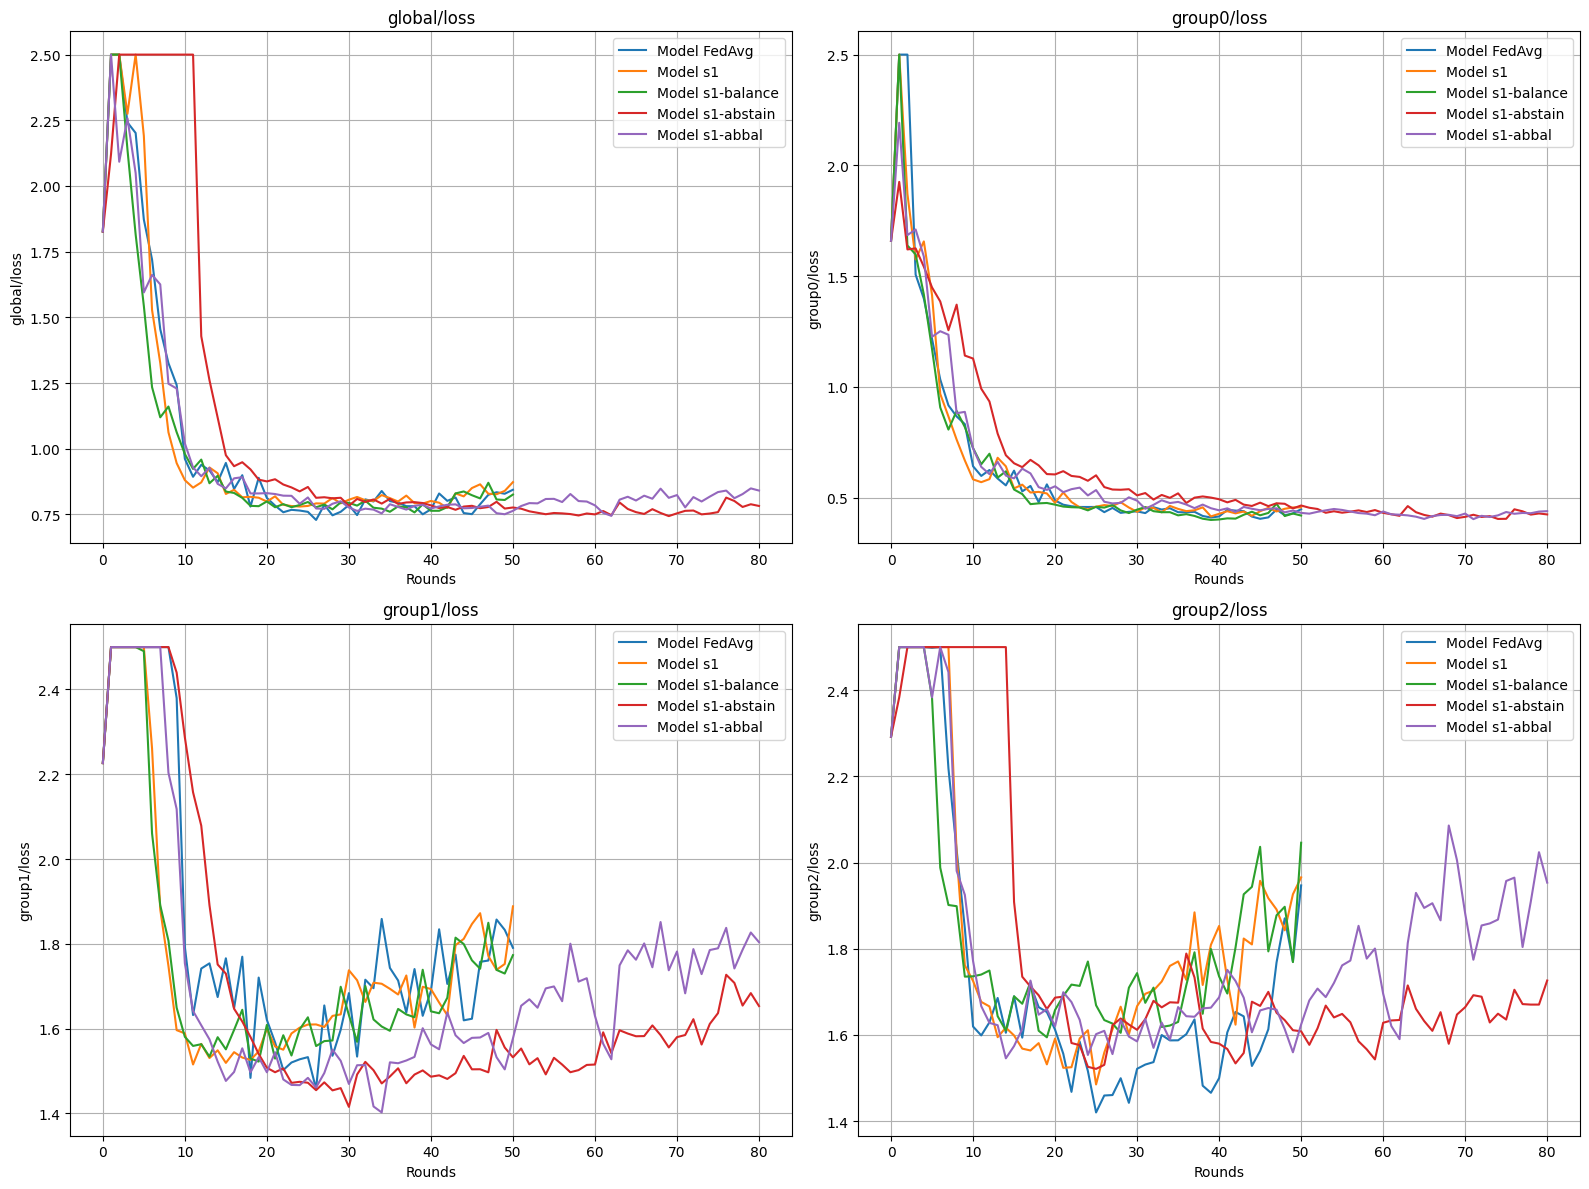

In [56]:
plot_scalar(lista, "loss")

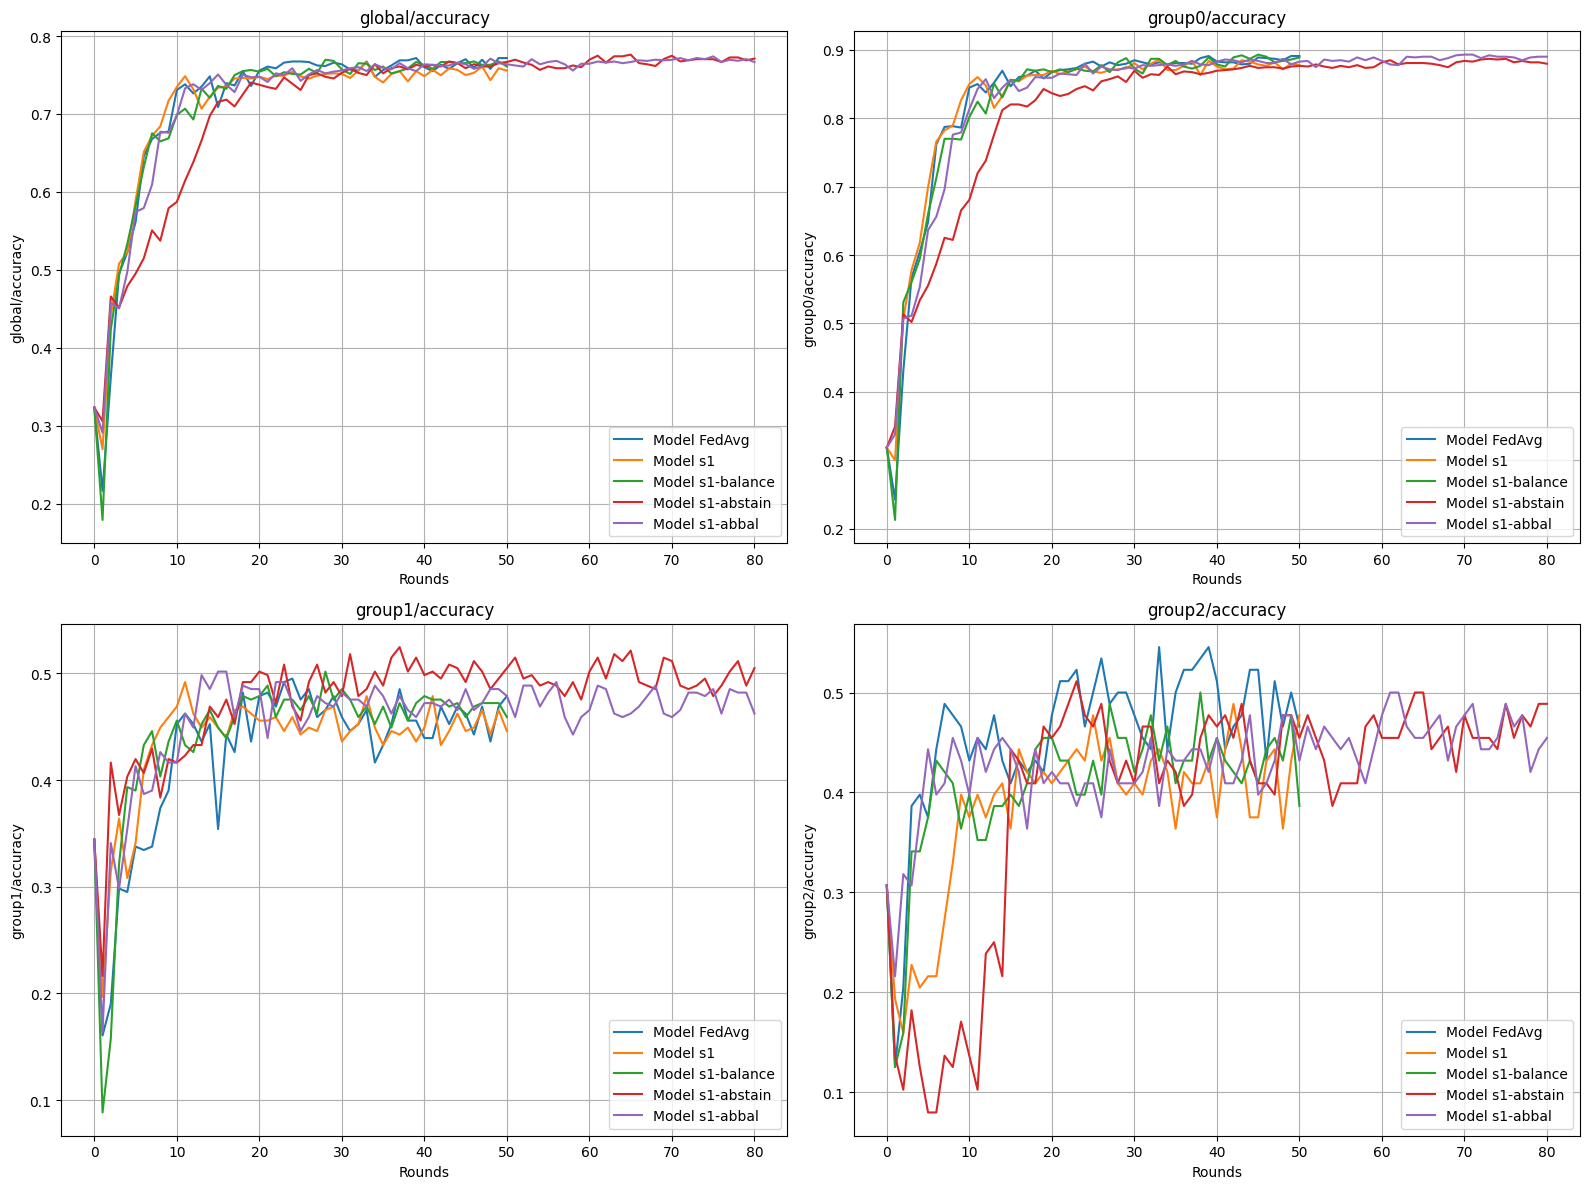

In [57]:
plot_scalar(lista, "accuracy")